In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from data_utils import load_dataset

# test

Below are the 3 regression datasets

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

Below is an implementation of the kNN algorithm for regression.

In [2]:
# first, implement distance metric as separate function
def minkowski_dists(x_train, x_test_i, l=2):
    
    """
    Returns Minkowski distance between each element
    of x_train and x_test_i as a (D,1) np array
    
    x_train is a (D,n) array
    x_test_i is a (n,) array
    
    dists is a (D,1) array
    """
    
    p = l
    x_test_i = x_test_i.reshape((1,-1)) # converts x_test_i to a (1,n) array
    # not necessary... will still work w/out this b/c broadcasting
    diff = np.abs(x_train-x_test_i)
    power = np.power(diff,p)
    sigma = np.sum(power,axis=1).reshape((x_train.shape[0],-1)) # axis = 1 --> sum along rows
    dists = np.power(sigma,1/p)
    return dists

def kNN_regress(x_train, y_train, x_test, k=1, l=2):
    
    """
    Returns y_predict results corresponding to x_test inputs using kNN algorithm
    
    x_train is a (D,n) array
    y_train is a (D,1) array (regression: single output)
    x_test is a (T,n) array
    
    y_predict is a (T,1) array (regression: single output)
    """
    
    num_test_points = x_test.shape[0]
    y_predict = np.empty((num_test_points,1),)
    
    # compute distances (for each test point)
    # assume distance metric is the Minkowski distance
    for i, x_test_i in enumerate(x_test):
        dists = minkowski_dists(x_train, x_test_i,l)
        partition = np.argpartition(dists,kth=k,axis=0) # returns indices of dists
                                                        # axis = 0 --> partition along column
        kNN = partition[:k]
        y_predict[i,0] = np.average(y_train[kNN,0])
    
    return y_predict

Implementation of v-fold cross-validation with v = 5:

In [3]:
def v_fold_cross_validation_RMSE(x_train, y_train, N, k=1, max_l=2, v=5, testing_runtime=False):
    
    """
    Conducts cross validation on x_train and y_train with v folds
    
    x_train and y_train are (N,n) arrays
    trains using kNN validation with k
    repeats model with different minkowski distance metric with p up to max_l
    
    Returns the average RMSE across the folds and for each p up to max_l
    RMSE_avg is a (1,max_l) array
    """
    
    # divide data into v equal folds
    # split data into folds (by index)
    idx = np.arange(N,dtype=int)
    if (N%v != 0):
        # as N is not be a perfect multiple of v, add in 'fake' numbers that will be cleaned later
        extra = np.random.choice(idx, size=N%v, replace=False)
        idx = np.delete(idx,extra)
        idx = np.random.permutation(idx).reshape((v,-1))
        temp = -1 * np.ones(idx.shape[0], dtype=int)
        temp[:extra.shape[0]] = extra
        temp = temp.reshape(idx.shape[0],1)
        idx = np.hstack((idx,temp))
    else:
        idx = np.random.permutation(idx).reshape((v,-1))
    
    RMSE = np.empty((v,max_l))
    
    # train and test for each fold
    for i in range(v):
        ith_fold_idx = idx[i]
        ith_fold_idx = [i for i in ith_fold_idx if i>=0]
        training_idx = np.delete(idx, i, axis=0)
        training_idx = training_idx.reshape(-1) # flatten the array
        training_idx = [i for i in training_idx if i>=0]
        
        x_tr, y_tr = x_train[training_idx], y_train[training_idx]
        x_val, y_val = x_train[ith_fold_idx], y_train[ith_fold_idx]
        
        for l in range(1,max_l+1,1):
            y_predict = kNN_regress(x_tr, y_tr, x_val, k=k, l=l)
            RMSE[i,l-1] = np.sqrt(np.mean(np.square(y_val-y_predict)))
        
    RMSE_avg = np.average(RMSE, axis=0)
    
    if not testing_runtime:
        print("k={}".format(k))
        for l in range(max_l):
            print("\tl={l}, RMSE={RMSE_avg}".format(l=l+1, RMSE_avg=round(RMSE_avg[l], 6)))
    
    return RMSE_avg 

def estimate_best_param(x_train, y_train, v=5, max_l=2):
    
    """
    Estimates the best k and l values for optimal model results (i.e., tunes the model parameters)
    Uses cross validation with v folds for tuning
    Repeats training with different minkowski distance metric with p up to max_l
    
    x_train and y_train are (N,n) arrays
    
    Returns average RMSE across folds for each k up to sqrt(N) and for each p up to max_l
    RMSE_avg is (sqrt(N),max_l) array
    Returns best_k and best_l --> ints
    """
    
    # assume training data includes both training and validation sets
    t0 = time.time()
    print("Running...")
    
    N = x_train.shape[0] # number of training points
    k_max = int(np.sqrt(N)) # rule of thumb: k < sqrt(N)
    RMSE_avg = np.empty((k_max,max_l)) # RMSE_avg[k][l] stores the average RMSE value for k, l distance metric
    
    # timing estimate
    t0 = time.time()
    print("Estimating running time...")
    v_fold_cross_validation_RMSE(x_train, y_train, N=N, k=k_max//2, max_l=max_l, v=v, testing_runtime=True)
    print("Estimated running time: {}s".format(round((time.time()-t0)*k_max,2)))
    
    # start parameter tuning
    t0 = time.time()
    print("Beginning parameter tuning...")
    
    for k in range(1, k_max+1, 1):
        RMSE_avg[k-1] = v_fold_cross_validation_RMSE(x_train, y_train, N=N, k=k, max_l=max_l, v=v)
    
    best_k, best_l = np.unravel_index(np.argmin(RMSE_avg), RMSE_avg.shape)
    best_k += 1
    best_l += 1
    print("Best: k={}, l={}; with min avg RMSE={}".format(best_k, best_l, round(RMSE_avg[best_k-1,best_l-1],6)))
    print("took {}s".format(round(time.time()-t0,2)))
    return RMSE_avg, best_k, best_l

Run mauna_loa dataset:

In [5]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
x_train = np.vstack([x_valid, x_train])
y_train = np.vstack([y_valid, y_train])

RMSE_avg, best_k, best_l = estimate_best_param(x_train, y_train, v=5, max_l=2)

Running...
Estimating running time...
Estimated running time: 0.97s
Beginning parameter tuning...
k=1
	l=1, RMSE=0.04799
	l=2, RMSE=0.04799
k=2
	l=1, RMSE=0.033208
	l=2, RMSE=0.033208
k=3
	l=1, RMSE=0.042815
	l=2, RMSE=0.042815
k=4
	l=1, RMSE=0.048852
	l=2, RMSE=0.048852
k=5
	l=1, RMSE=0.056803
	l=2, RMSE=0.056803
k=6
	l=1, RMSE=0.062763
	l=2, RMSE=0.062763
k=7
	l=1, RMSE=0.072198
	l=2, RMSE=0.072198
k=8
	l=1, RMSE=0.077739
	l=2, RMSE=0.077739
k=9
	l=1, RMSE=0.084986
	l=2, RMSE=0.084986
k=10
	l=1, RMSE=0.08933
	l=2, RMSE=0.08933
k=11
	l=1, RMSE=0.091935
	l=2, RMSE=0.091935
k=12
	l=1, RMSE=0.093833
	l=2, RMSE=0.093833
k=13
	l=1, RMSE=0.093958
	l=2, RMSE=0.093958
k=14
	l=1, RMSE=0.093122
	l=2, RMSE=0.093122
k=15
	l=1, RMSE=0.09107
	l=2, RMSE=0.09107
k=16
	l=1, RMSE=0.088793
	l=2, RMSE=0.088793
k=17
	l=1, RMSE=0.084866
	l=2, RMSE=0.084866
k=18
	l=1, RMSE=0.080816
	l=2, RMSE=0.080816
k=19
	l=1, RMSE=0.078125
	l=2, RMSE=0.078125
k=20
	l=1, RMSE=0.075088
	l=2, RMSE=0.075088
k=21
	l=1, RMSE=0

Use best k and l to test model and find test RMSE:

In [6]:
def test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l):
    # run model
    y_predict = kNN_regress(x_train, y_train, x_test, k=best_k, l=best_l)
    
    # find RMSE between y_predict and y_test
    RMSE_test = np.sqrt(np.mean(np.square(y_predict-y_test)))
    
    return RMSE_test

In [7]:
RMSE_test = test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l)
print("RMSE of model on test data for k={k} and l={l}: {RMSE_test}".format(k=best_k, l=best_l, RMSE_test=RMSE_test))

RMSE of model on test data for k=2 and l=1: 0.44070489035463933


RMSE vs k plot for mauna_loa dataset:

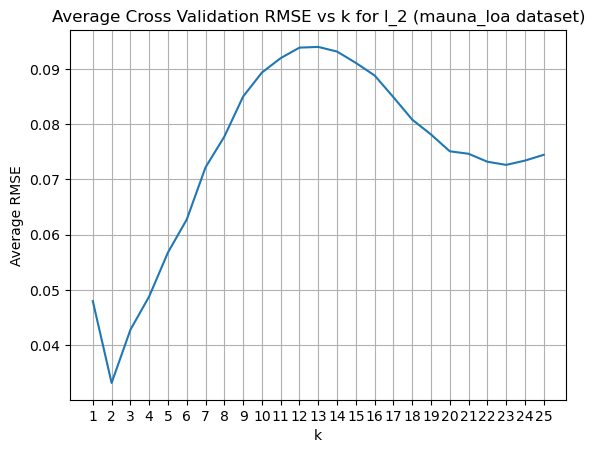

In [8]:
plt.figure()
plt.title("Average Cross Validation RMSE vs k for l_2 (mauna_loa dataset)")
plt.xlabel('k')
plt.ylabel('Average RMSE')
k_max = int(np.sqrt(x_train.shape[0]))
l = 2
x_axis = np.arange(k_max) + 1
y_axis = RMSE_avg[:,l-1]
plt.grid(visible=True)
plt.xticks(range(min(x_axis), max(x_axis)+1))
plt.plot(x_axis, y_axis)

We see k = 2 is the location of min RMSE. However, we also have k = 23 as a local min and k = 12 as the max. Let's plot the regression model predictions for k = 2, k = 23, and k = 12 and compare with the actual test targets:

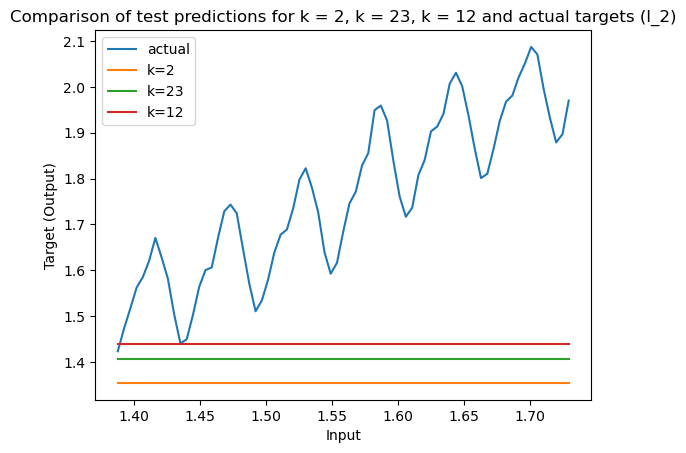

In [9]:
plt.figure()
plt.title("Comparison of test predictions for k = 2, k = 23, k = 12 and actual targets (l_2)")
plt.xlabel("Input")
plt.ylabel("Target (Output)")
plt.plot(x_test, y_test, label='actual')
y_predict_k2 = kNN_regress(x_train, y_train, x_test, k=2, l=2)
y_predict_k23 = kNN_regress(x_train, y_train, x_test, k=23, l=2)
y_predict_k12 = kNN_regress(x_train, y_train, x_test, k=12, l=2)
plt.plot(x_test, y_predict_k2, label="k=2")
plt.plot(x_test, y_predict_k23, label="k=23")
plt.plot(x_test, y_predict_k12, label="k=12")
plt.legend(loc='best')

As we can see, the predictions for all three predictions are not close at all, not even the behaviour of the data is captured. k = 12 is slightly closer to the actual targets than the other predictions.

Let's also plot the regression model for the training set:

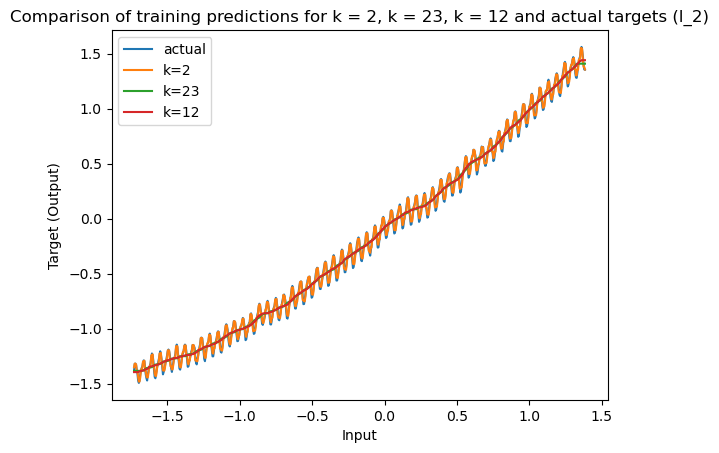

In [10]:
plt.figure()
plt.title("Comparison of training predictions for k = 2, k = 23, k = 12 and actual targets (l_2)")
plt.xlabel("Input")
plt.ylabel("Target (Output)")
plt.plot(x_train, y_train, label='actual')
y_predict_k2 = kNN_regress(x_train, y_train, x_train, k=2, l=2)
y_predict_k23 = kNN_regress(x_train, y_train, x_train, k=23, l=2)
y_predict_k12 = kNN_regress(x_train, y_train, x_train, k=12, l=2)
plt.plot(x_train, y_predict_k2, label="k=2")
plt.plot(x_train, y_predict_k23, label="k=23")
plt.plot(x_train, y_predict_k12, label="k=12")
plt.legend(loc='best')

As we can see, the model for k = 2 overfits the training data and the models for k = 23 and k = 12 underfit the training data (it is difficult to see the difference between k = 23 and k = 12, they are almost identical).

Run rosenbrock dataset:

In [11]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)
x_train = np.vstack([x_valid, x_train])
y_train = np.vstack([y_valid, y_train])

RMSE_avg, best_k, best_l = estimate_best_param(x_train, y_train, v=5, max_l=2)
RMSE_test = test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l)
print("RMSE of model on test data for k={k} and l={l}: {RMSE_test}".format(k=best_k, l=best_l, RMSE_test=RMSE_test))

Running...
Estimating running time...
Estimated running time: 15.28s
Beginning parameter tuning...
k=1
	l=1, RMSE=0.287969
	l=2, RMSE=0.261212
k=2
	l=1, RMSE=0.304182
	l=2, RMSE=0.294051
k=3
	l=1, RMSE=0.341654
	l=2, RMSE=0.318384
k=4
	l=1, RMSE=0.340507
	l=2, RMSE=0.337352
k=5
	l=1, RMSE=0.361456
	l=2, RMSE=0.348835
k=6
	l=1, RMSE=0.345
	l=2, RMSE=0.348655
k=7
	l=1, RMSE=0.415428
	l=2, RMSE=0.39921
k=8
	l=1, RMSE=0.382101
	l=2, RMSE=0.376904
k=9
	l=1, RMSE=0.401262
	l=2, RMSE=0.398832
k=10
	l=1, RMSE=0.393046
	l=2, RMSE=0.398002
k=11
	l=1, RMSE=0.385628
	l=2, RMSE=0.380455
k=12
	l=1, RMSE=0.420942
	l=2, RMSE=0.416909
k=13
	l=1, RMSE=0.43082
	l=2, RMSE=0.431777
k=14
	l=1, RMSE=0.464441
	l=2, RMSE=0.455122
k=15
	l=1, RMSE=0.456849
	l=2, RMSE=0.448049
k=16
	l=1, RMSE=0.461656
	l=2, RMSE=0.455151
k=17
	l=1, RMSE=0.484526
	l=2, RMSE=0.47748
k=18
	l=1, RMSE=0.477233
	l=2, RMSE=0.468585
k=19
	l=1, RMSE=0.49088
	l=2, RMSE=0.489145
k=20
	l=1, RMSE=0.521929
	l=2, RMSE=0.515053
k=21
	l=1, RMSE=0

Run pumadyn32nm dataset:

In [12]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
x_train = np.vstack([x_valid, x_train])
y_train = np.vstack([y_valid, y_train])

RMSE_avg, best_k, best_l = estimate_best_param(x_train, y_train, v=5, max_l=2)
RMSE_test = test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l)
print("RMSE of model on test data for k={k} and l={l}: {RMSE_test}".format(k=best_k, l=best_l, RMSE_test=RMSE_test))

Running...
Estimating running time...
Estimated running time: 3317.49s
Beginning parameter tuning...
k=1
	l=1, RMSE=1.217596
	l=2, RMSE=1.230967
k=2
	l=1, RMSE=1.044464
	l=2, RMSE=1.051179
k=3
	l=1, RMSE=0.962998
	l=2, RMSE=0.988187
k=4
	l=1, RMSE=0.931839
	l=2, RMSE=0.958048
k=5
	l=1, RMSE=0.91642
	l=2, RMSE=0.936158
k=6
	l=1, RMSE=0.904413
	l=2, RMSE=0.929314
k=7
	l=1, RMSE=0.896374
	l=2, RMSE=0.919467
k=8
	l=1, RMSE=0.888865
	l=2, RMSE=0.908602
k=9
	l=1, RMSE=0.891144
	l=2, RMSE=0.908874
k=10
	l=1, RMSE=0.887489
	l=2, RMSE=0.909303
k=11
	l=1, RMSE=0.883799
	l=2, RMSE=0.906176
k=12
	l=1, RMSE=0.883136
	l=2, RMSE=0.906018
k=13
	l=1, RMSE=0.882547
	l=2, RMSE=0.899199
k=14
	l=1, RMSE=0.877394
	l=2, RMSE=0.89962
k=15
	l=1, RMSE=0.875894
	l=2, RMSE=0.895363
k=16
	l=1, RMSE=0.874704
	l=2, RMSE=0.896436
k=17
	l=1, RMSE=0.875946
	l=2, RMSE=0.898515
k=18
	l=1, RMSE=0.872801
	l=2, RMSE=0.897869
k=19
	l=1, RMSE=0.872066
	l=2, RMSE=0.895094
k=20
	l=1, RMSE=0.873934
	l=2, RMSE=0.898163
k=21
	l=1,